# Binary classification - single_model using Naive Bayes(sultan_features)

# Importing and Preprocessing

## Importing libraries

In [19]:
#### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

# Gathering required features

In [20]:
df = pd.read_pickle("./sultan_features.pkl")
df = df.fillna(0)

In [21]:
short_df = df[['question_id','question','student_answer','student_modified','ref_modified', \
               'grade','length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
short_df['status'] = short_df['grade'] >= 3
short_df['status'] = short_df['status'].astype(int)

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Sultan features

In [22]:
X = short_df[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
# X['cos_similarity_demo'].isnull().sum().sum()
# X[X.isnull().any(1)]

In [23]:
X = short_df[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
X[X<0] = 0
Y = short_df['status'].values
X = np.array(X)

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/pandas/core/frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


# Seeding

In [24]:
#getting the seed index
classes = short_df['status'].unique()
seed_index = []
for i in classes:
    seed_index.append(short_df['status'][short_df['status']==i].index[0])
seed_index

[0, 5]

In [34]:
act_data = short_df.copy()
accuracy_list = []

# initialising
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
# lr = LogisticRegression()
nb = SVC(kernel='linear', probability=True)
learner = ActiveLearner(
#     estimator = lr,
    estimator = nb,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = int(len(X)/10)
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
#     print("\nQ: ", act_data.loc[int(query_idx),'question'])
#     print("A: ",act_data.loc[int(query_idx),'student_answer'])
#     print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
#     human_label = int(input("\nGive me a grade 0 or 1:"))
    
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X_pool,y_pool))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
print("======================================")
print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data"  )

Accuracy after query no. 1: 0.545715
Accuracy after query no. 2: 0.545529
Accuracy after query no. 3: 0.545343
Accuracy after query no. 4: 0.494663
Accuracy after query no. 5: 0.595893
Accuracy after query no. 6: 0.466311
Accuracy after query no. 7: 0.542951
Accuracy after query no. 8: 0.832237
Accuracy after query no. 9: 0.675031
Accuracy after query no. 10: 0.834568
Accuracy after query no. 11: 0.759572
Accuracy after query no. 12: 0.850494
Accuracy after query no. 13: 0.843840
Accuracy after query no. 14: 0.822754
Accuracy after query no. 15: 0.823505
Accuracy after query no. 16: 0.833746
Accuracy after query no. 17: 0.834503
Accuracy after query no. 18: 0.830718
Accuracy after query no. 19: 0.852127
Accuracy after query no. 20: 0.870661
Accuracy after query no. 21: 0.876809
Accuracy after query no. 22: 0.880480
Accuracy after query no. 23: 0.877120
Accuracy after query no. 24: 0.877483
Accuracy after query no. 25: 0.874534
Accuracy after query no. 26: 0.871582
Accuracy after query 

Accuracy after query no. 216: 0.906924
Accuracy after query no. 217: 0.906883
Accuracy after query no. 218: 0.907291
Accuracy after query no. 219: 0.907699
Accuracy after query no. 220: 0.907658
Accuracy after query no. 221: 0.908067
Accuracy after query no. 222: 0.908025
Accuracy after query no. 223: 0.908435
Accuracy after query no. 224: 0.908845
Accuracy after query no. 225: 0.908804
Accuracy after query no. 226: 0.908762
Accuracy after query no. 227: 0.908721
Accuracy after query no. 228: 0.908680
Accuracy after query no. 229: 0.908639
Accuracy after query no. 230: 0.909050
Accuracy after query no. 231: 0.909009
Accuracy after query no. 232: 0.908967
Accuracy after query no. 233: 0.908926
Accuracy after query no. 234: 0.908885
Accuracy after query no. 235: 0.908844
Accuracy after query no. 236: 0.909256
Accuracy after query no. 237: 0.909215
Accuracy after query no. 238: 0.909173
Accuracy after query no. 239: 0.909587
Accuracy after query no. 240: 0.909545
Accuracy after query no. 

## Regular supervised task

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)

In [32]:
# logisticRegr = LogisticRegression()
nb.fit(X_train, Y_train)
score = nb.score(X_test, Y_test)

print(score)

0.8609406952965235


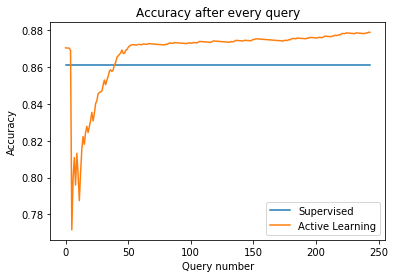

In [33]:
supervised_accuracy = [score for x in range(0,n_queries)]

plt.figure()
plt.plot(np.linspace(0,n_queries-1,n_queries),supervised_accuracy)
plt.plot(accuracy_list)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised", "Active Learning"], loc="lower right")
plt.show()